# How to shuttle electrons (first part of the junction)

This notebook will consider a simple linear trap and do some shuttling. This is a preliminary work before the junction analysis.

**Import zone**

In [7]:
# Import needed packages
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.constants as ct

# Import some classes and functions from the 'electrode' package
from electrode import (System, PolygonPixelElectrode, shaped)

# Import function for shims calculations
from shims import calc_shims 

# set numpy precision to 4 decimals
np.set_printoptions(precision=4)

# Python magic needed for matplotlib
%matplotlib inline

In [8]:
# Wanted trap depth
h = 50

# Dimensions of the central DC electrode (cross-shaped)
C_length = 6000
C_width = 0.83 * h

# Width of the RF electrodes
RF1_width = RF2_width = 2 * h

# Dimensions of the external DC electrodes -> I could do different widths or lengths in principle.
DC_width = 4 * C_width
DC_length = 1600

# Number of DC electrodes
DC_num_B = 11
DC_num_T = 11

print(f'RF gap width = {C_width:.1f} μm')
print(f'RF width = {RF1_width:.1f} μm')
print(f'DC width = {DC_width:.1f} μm')

RF gap width = 41.5 μm
RF width = 100.0 μm
DC width = 166.0 μm


In [9]:
def plot_potential_sections(s, x_cut, y_cut, z_cut, x0, xss, xmin, xmax, ymin, ymax, zmin, zmax, n, v_min, v_max, v, p_tot0): 
    fig = plt.figure(figsize=(15, 8))
    
    # (1) x-y cross section
    ax0 = plt.subplot2grid((2,2), (0,0))
    ax0.set_title("x-y cross section at minimum z = {0:.3g} um".format(z_cut))
    ax0.set_xlabel('x (um)')
    ax0.set_ylabel('y (um)')
    
    # Build grid (z kept constant) and compute potential on the 2D plane
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+.1]
    pot = shaped(s.potential)(xyz)
    
    # Reshape data as 2D arrays for contour plot
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    
    # Plot contour lines
    CS = ax0.contour(x, y, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    
    # Build heatmap of potential (wrt to the potential in x0 set to 0).
    im = ax0.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(xmin, xmax, ymin, ymax))
    ax0.scatter(x0[0], x0[1], color='cyan', marker='o', s=10) # Plot minimum
    for xs in xss:
        ax0.scatter(xs[0], xs[1], color='cyan', marker='o', s=10) # Plot saddle point
    im.set_interpolation('bilinear') # For avoiding pixelation
    cb = fig.colorbar(im, ax=ax0, shrink=0.8) # Adding colorbar
    
    
    # (2) x-z cross section
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax1.set_title("x-z cross section at minimum y={0:.3g}um".format(y_cut))
    ax1.set_xlabel('x (um)')
    ax1.set_ylabel('z (um)')
    
    # Now y is kept constant
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+.1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n,n) for _ in (xyz[0], xyz[2], pot))
    CS = ax1.contour(x, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    im = ax1.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(xmin,xmax,zmin,zmax))
    ax1.scatter(x0[0], x0[2], color='cyan', marker='o', s=10)
    for xs in xss:
        ax1.scatter(xs[0], xs[2], color='cyan', marker='o', s=10)
    im.set_interpolation('bilinear')
    cb = fig.colorbar(im, ax=ax1, shrink=0.8)
    
    
    # y-z cross section (uses two rows)
    ax2 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax2.set_title("y-z cross section at minimum x={0:.3g}um".format(x_cut))
    ax2.set_xlabel('y (um)')
    ax2.set_ylabel('z (um)')
    
    # Here x is kept constant
    xyz = np.mgrid[x_cut:x_cut+.1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    y, z, p = (_.reshape(n,n) for _ in (xyz[1], xyz[2], pot))
    CS = ax2.contour(y, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
    im = ax2.imshow((p-p_tot0).T, origin='lower', vmin=v_min, vmax=v_max, 
                    extent=(ymin,ymax,zmin,zmax))
    ax2.scatter(x0[1], x0[2], color='cyan', marker='o', s=10)
    for xs in xss:
        ax2.scatter(xs[1], xs[2], color='cyan', marker='o', s=10)
    im.set_interpolation('bilinear')
    cb = fig.colorbar(im, ax=ax2, shrink=0.8)

In [10]:
def generate_dc_electrodes(n, dc_length, gnd_width, rf_width, dc_width):
  dc_electrodes = []

  # Base height for DC electrodes
  y_offset = gnd_width / 2 + rf_width

  for i in range(n):
    x1 = (-n / 2 + i) * dc_width
    x2 = x1 + dc_width
    electrode_name = f"DC_{i+1}"

    electrode = (electrode_name, [[(x1, y_offset + dc_length),
                                   (x1, y_offset),
                                   (x2, y_offset),
                                   (x2, y_offset + dc_length)]])
    dc_electrodes.append(electrode)

  # Mirror the electrodes to the bottom side
  y_offset = -(gnd_width / 2 + rf_width)

  for i in range(n):
    x1 = (-n / 2 + i) * dc_width
    x2 = x1 + dc_width
    electrode_name = f"DC_{n + i + 1}"

    electrode = (electrode_name, [[(x1, y_offset),
                                   (x1, y_offset - dc_length),
                                   (x2, y_offset - dc_length),
                                   (x2, y_offset)]])
    dc_electrodes.append(electrode)

  return dc_electrodes

In [11]:
# Define the list that contains the electrode
electrodes = []

# Central DC electrode
C_electrode = ("C", [[(-C_length/2, C_width/2),  # Top left
                           (-C_length/2, -C_width/2), # Bottom left
                           (C_length/2, -C_width/2),  # Bottom right
                           (C_length/2, C_width/2)]]) # Top right

# Add the central DC electrode to the list
electrodes += [C_electrode]

# Top and bottom RF electrodes
RF_electrodes = [("RF1", [[(-C_length/2, C_width/2 + RF1_width), 
                           (-C_length/2, C_width/2), 
                           (C_length/2, C_width/2), 
                           (C_length/2, C_width/2 + RF1_width)]]),
                 ("RF2", [[(-C_length/2, -C_width/2), 
                           (-C_length/2, -C_width/2-RF2_width), 
                           (C_length/2, -C_width/2-RF2_width), 
                           (C_length/2, -C_width/2)]])]

# Add the RF electrodes to the list
electrodes += RF_electrodes

# DC electrodes
DC_electrodes = generate_dc_electrodes(DC_num_T, DC_length, C_width, RF1_width, DC_width)

# Add the other DC electrode to the list
electrodes += DC_electrodes

In [12]:
# Build the system of electrodes
s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p)) for n, p in electrodes])

In [13]:
for e in s:
    print(e.name, e.paths)

C [array([[-3000.  ,    20.75],
       [-3000.  ,   -20.75],
       [ 3000.  ,   -20.75],
       [ 3000.  ,    20.75]])]
RF1 [array([[-3000.  ,   120.75],
       [-3000.  ,    20.75],
       [ 3000.  ,    20.75],
       [ 3000.  ,   120.75]])]
RF2 [array([[-3000.  ,   -20.75],
       [-3000.  ,  -120.75],
       [ 3000.  ,  -120.75],
       [ 3000.  ,   -20.75]])]
DC_1 [array([[-913.  , 1720.75],
       [-913.  ,  120.75],
       [-747.  ,  120.75],
       [-747.  , 1720.75]])]
DC_2 [array([[-747.  , 1720.75],
       [-747.  ,  120.75],
       [-581.  ,  120.75],
       [-581.  , 1720.75]])]
DC_3 [array([[-581.  , 1720.75],
       [-581.  ,  120.75],
       [-415.  ,  120.75],
       [-415.  , 1720.75]])]
DC_4 [array([[-415.  , 1720.75],
       [-415.  ,  120.75],
       [-249.  ,  120.75],
       [-249.  , 1720.75]])]
DC_5 [array([[-249.  , 1720.75],
       [-249.  ,  120.75],
       [ -83.  ,  120.75],
       [ -83.  , 1720.75]])]
DC_6 [array([[ -83.  , 1720.75],
       [ -83.  ,  12

In [14]:
# Set central DC electrode voltage
s["C"].dc = 1.

# Set RF electrodes voltages
s["RF1"].rf = -1.
s["RF2"].rf = -1.

# Set DC electrodes voltages
for i in range(DC_num_B):
    s[f'DC_{i+1}'].dc = 0.5 * (-1) ** i
    
for i in range(DC_num_B):
    s[f'DC_{i+12}'].dc = 0.5 * (-1) ** i

# Print voltages on electrodes -> if a voltage is not present (like the RF on a DC) there will be a 0
print("RF-voltages on the electrodes: {}".format(s.rfs))
print("DC-voltages on the electrodes: {}".format(s.dcs))

RF-voltages on the electrodes: [ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
DC-voltages on the electrodes: [ 1.   0.   0.   0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5
  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5]


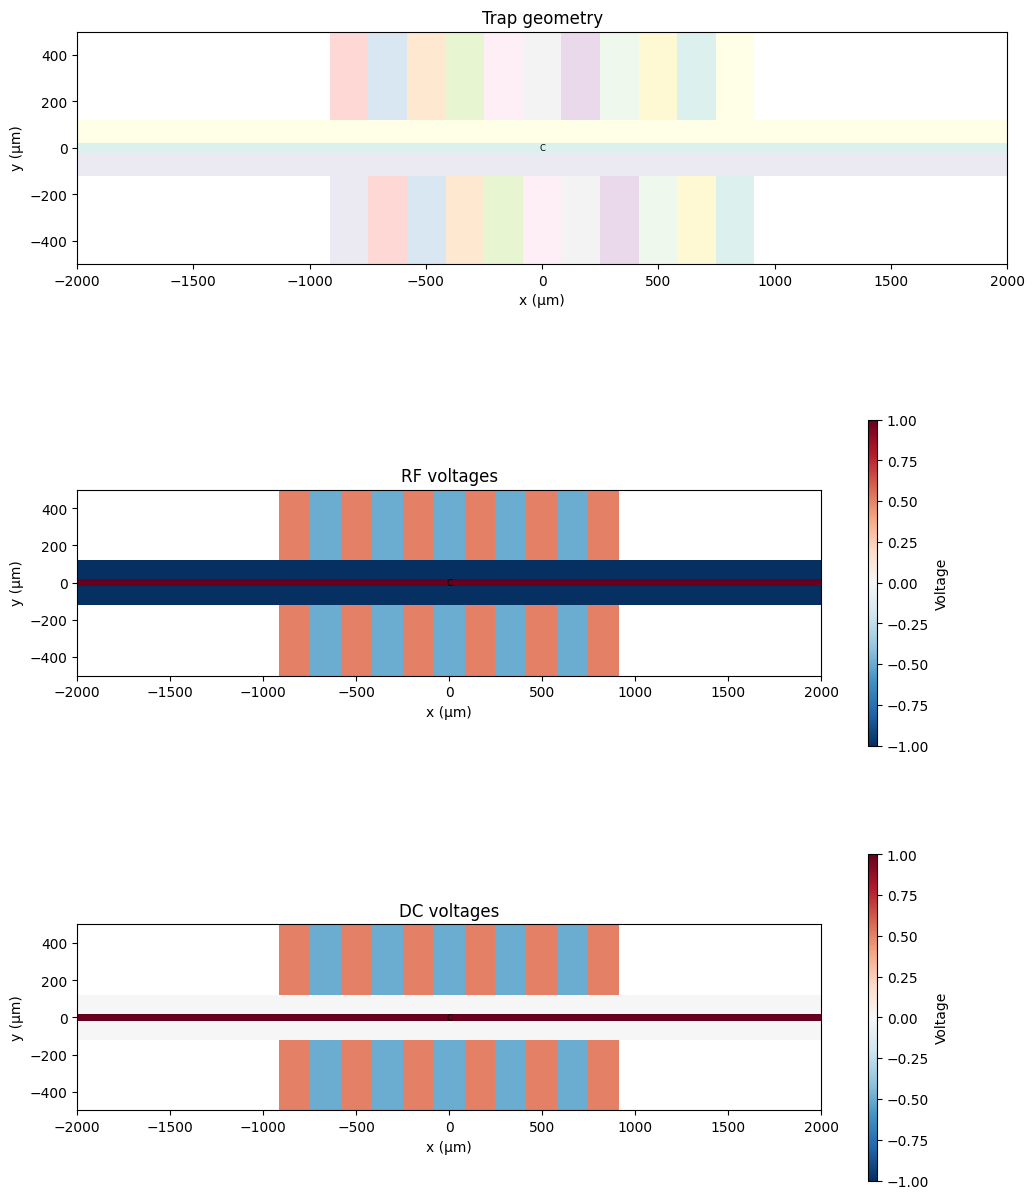

In [15]:
# Build figure and axes objects, needed for the plotting functions of the electrode package
fig, ax = plt.subplots(3, 1, figsize=(12,16))

# Plot the electrode geometry
s.plot(ax[0])

# Plots the voltages on the RF electrodes
s.plot_voltages(ax[1], u=s.rfs+s.dcs)

# Plots the voltages on the DC electrodes
s.plot_voltages(ax[2], u=s.dcs)

# Compute minimum and maximum voltage
vmin = np.min([np.min(s.rfs), np.min(s.dcs)])
vmax = np.max([np.max(s.rfs), np.max(s.dcs)])

# Build colormap for colorbars (normalized on voltage limit values)
cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Build colormap for the RF voltages plot
cb1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], shrink=0.9, aspect=35)
cb1.ax.tick_params(labelsize=10)
cb1.set_label('Voltage', fontsize = 10)

# Build colormap for the DC voltages plot
cb2 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[2], shrink=0.9, aspect=35)
cb2.ax.tick_params(labelsize=10)
cb2.set_label('Voltage', fontsize = 10)

# Set titles
ax[0].set_title("Trap geometry")
ax[1].set_title("RF voltages")
ax[2].set_title("DC voltages")

# Set plot limits
xmax = 2000
ymax = 500

# Set properties
for axi in ax.flat:
    axi.set_aspect("equal") # Set equal aspect ratio (on all axes)
    axi.set_xlim(-xmax, xmax)
    axi.set_ylim(-ymax, ymax)
    axi.set_xlabel('x (μm)')
    axi.set_ylabel('y (μm)')

In [16]:
# Define subsystems sorted into RF and DC electrodes
s_RF = System([entry for entry in s if not entry.dc])
s_DC = System([entry for entry in s if not entry.rf])

# Check which electrode is in which subsystem
print("RF-electrodes: {}".format(s_RF.names))
print("DC-electrodes: {}".format(s_DC.names))

RF-electrodes: ['RF1', 'RF2']
DC-electrodes: ['C', 'DC_1', 'DC_2', 'DC_3', 'DC_4', 'DC_5', 'DC_6', 'DC_7', 'DC_8', 'DC_9', 'DC_10', 'DC_11', 'DC_12', 'DC_13', 'DC_14', 'DC_15', 'DC_16', 'DC_17', 'DC_18', 'DC_19', 'DC_20', 'DC_21', 'DC_22']


In [17]:
L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)

V_RF = 10.2 # RF peak voltage
Omega = 2 * np.pi * 20e6 # RF frequency in rad/s

# RF voltage applied to the electrodes parametrized so that the resulting potential equals the RF pseudo-potential in eV
U_RF = V_RF * np.sqrt(Q / M) / (2 * L * Omega)

print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))
print("Parametrized RF voltage: {} V".format(U_RF))

RF drive frequency: 20 MHz
RF voltage: 10.2 V
Parametrized RF voltage: 63.03198211516673 V


In [18]:
# Set all voltages to 0
for electrode in s:
    electrode.dc = 0
    electrode.rf = 0

# Turn on only RF voltages -> we set them equal to the chosen value of energy
for electrode in s_RF:
    electrode.rf = U_RF
    
print("DC electrodes and their voltages:")

for e in s_DC:
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

# Print RF parameters
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))

print("-------------------")

# Compute minimum again
try:
    x0 = s.minimum(x0=(0., 10., 10.), axis=(0,1,2), coord=np.identity(3))
    p_tot0 = s.potential(x0, 0)[0]
    print("The minimum of pseudopotential is: {0:.3g} eV\
          \nThe position of the minimum is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tot0, x0[0], x0[1], x0[2]))
except:
    print("minimum not found")
    x0 = (0., 0., 10.)
    
print("-------------------")

# Search for saddle point
xs_start, ys_start, zs_start = x0[0], x0[1], x0[2] + 70
print("Initialization to find the saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs, p_tots = s.saddle([xs_start, ys_start, zs_start])
    print("The saddle point energy is: {0:.3g} eV \
          \nThe position of the saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots, xs[0], xs[1], xs[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Compute secular frequencies
try:
    curve_z = s.modes(x0)
    omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")
    
print("-------------------")
    
# Compute maximum q-factor
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

DC electrodes and their voltages:
C: 0
DC_1: 0
DC_2: 0
DC_3: 0
DC_4: 0
DC_5: 0
DC_6: 0
DC_7: 0
DC_8: 0
DC_9: 0
DC_10: 0
DC_11: 0
DC_12: 0
DC_13: 0
DC_14: 0
DC_15: 0
DC_16: 0
DC_17: 0
DC_18: 0
DC_19: 0
DC_20: 0
DC_21: 0
DC_22: 0
-------------------
RF drive frequency: 20 MHz
RF voltage: 10.2 V
-------------------
The minimum of pseudopotential is: 2.98e-13 eV          
The position of the minimum is: (9.89e-21, 1.93e-05, 50) um
-------------------
Initialization to find the saddle point: 9.89e-21, 1.93e-05, 120
Saddle point not found
-------------------
Secular frequencies: (1.66e-06, 2.804, 2.804) MHz
in directions [ 1.0000e+00 -5.7267e-27 -2.4750e-21], [4.5427e-22 9.8301e-01 1.8354e-01], [ 2.4330e-21 -1.8354e-01  9.8301e-01]
-------------------
max q-parameter 0.397, max q-param per Volt 0.0389
--> apply 10.3V for max q=0.4


In [19]:
for line in s.analyze_static(x0, axis=(1, 2), m=M, q=Q, l=L, o=Omega):
    print(line)

parameters:
 f=20 MHz, m=40 amu, q=1 qe, l=1 µm, scale=6.18 V'/V_SI
corrdinates:
 analyze point: [9.8922e-21 1.9303e-05 5.0028e+01]
               ([9.8922e-21 1.9303e-05 5.0028e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 3e-13 eV
 saddle offset: [-2.9717e-02 -1.9304e-05  6.5326e-05]
               ([-2.9717e-02 -1.9304e-05  6.5326e-05] µm)
 saddle height: -3e-13 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [-2.0803e-29  2.4838e-09 -8.4050e-09] eV/l
           ([-2.0803e-23  2.4838e-03 -8.4050e-03] eV/m)
modes:
 pp+dc normal curvatures: [-4.5108e-17  1.2867e-04  1.2867e-04]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [ 1.0000e+00 -5.7267e-27 -2.4750e-21]
  b: 2.804 MHz, [4.5427e-22 9.8301e-01 1.8354e-01]
  c: 2.804 MHz, [ 2.4330e-21 -1.8354e-01  9.8301e-01]
  euler angles (rzxz): [ 7.5951e-19  1.0576e+01 -7.7264e-19] deg
 mathieu modes:
  a: 2.59

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:880: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


In [20]:
# 1D plot settings
n = 200 # resolution of meshgrid (for 2D plots)

zmin1D = 70.
zmax1D = 350.
xmin1D = -1.5*abs(x0[0])
xmax1D = 1.5*abs(x0[0])
ymin1D = -1500.
ymax1D = 1500.

x_cut, y_cut, z_cut = x0

potmin1D = -50.
potmax1D = 1500. # in meV

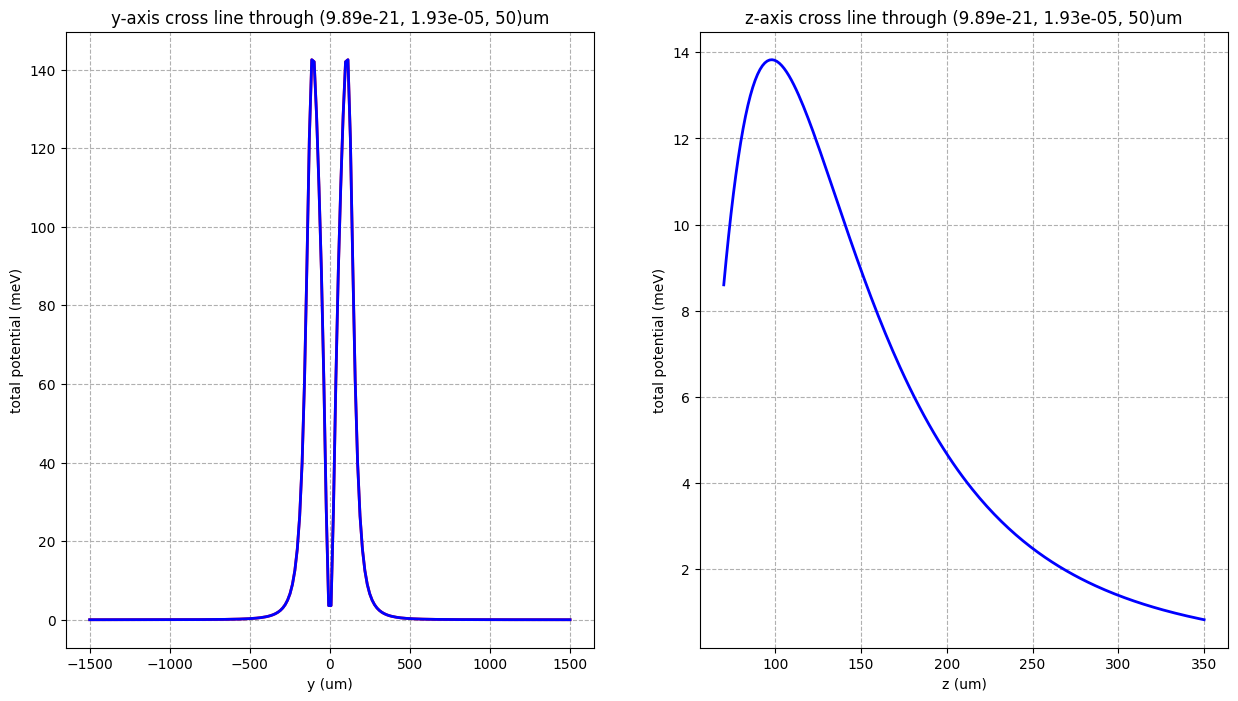

In [21]:
# Get data of cross line along y-direction
cross_line_y = np.mgrid[ymin1D:ymax1D:n*1j]
line_pot_y = np.copy(cross_line_y)
line_pot_y_b = np.copy(cross_line_y)
for i in range(0,n):
    x, y, z = x_cut, cross_line_y[i], z_cut
    line_pot_y[i] = s.potential((x,y,z), 0)[0]
    x, y, z = -x_cut, cross_line_y[i], z_cut
    line_pot_y_b[i] = s.potential((x,y,z), 0)[0]

# Get data of cross line along z-direction
cross_line_z = np.mgrid[zmin1D:zmax1D:n*1j]
line_pot_z = np.copy(cross_line_z)
for i in range(0,n):
    x, y, z = x_cut, y_cut, cross_line_z[i]
    line_pot_z[i] = s.potential((x,y,z), 0)[0]
    
# create figure to plot cross lines
fig, ax = plt.subplots(1,2,figsize=(15,8))

# Plot cross line along y
ax[0].plot(cross_line_y, (line_pot_y-p_tot0)*1e3, 'r', lw=2) # cross line pos x direction
ax[0].plot(cross_line_y, (line_pot_y_b-p_tot0)*1e3, 'b', lw=2) # cross line neg x direction
ax[0].grid(linestyle='--')
ax[0].set_xlabel('y (um)')
ax[0].set_ylabel('total potential (meV)')
ax[0].set_title('y-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

# Plot cross line along x
ax[1].plot(cross_line_z, (line_pot_z-p_tot0)*1e3, 'b', lw=2)
ax[1].grid(linestyle='--')
ax[1].set_xlabel('z (um)')
ax[1].set_ylabel('total potential (meV)')
ax[1].set_title('z-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

plt.show()

In [22]:
derivs = "xx x y z"
u_cal = calc_shims(x0, s_DC, derivs)
    
uxx = np.array(u_cal['xx'] * 1e-4)
ux = np.array(u_cal['x'] * 1e-2)
uy = np.array(u_cal['y'] * 1e-2)
uz = np.array(u_cal['z'] * 1e-2)
    
for i, e in enumerate(s_DC):
    e.dc = uxx[i]        

x0 = s.minimum(x0=x0, axis=(1,2), coord=np.identity(3))

curve_z = s.modes(x0)
omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    
target_freq = 0.7e6 * 2 * np.pi  # Convert MHz to angular frequency
k = target_freq / omega_sec[0]

# Scale the DC voltages
for i, e in enumerate(s_DC):
    e.dc *= k**2
    
uxx *= k**2

In [23]:
u_set = uxx
print("DC electrodes and their voltages:")

for i, e in enumerate(s_DC):
    e.dc = np.array(u_set[i])
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

DC electrodes and their voltages:
C: -0.21802130770731198
DC_1: 0.011236775750204145
DC_2: 0.02409648644281135
DC_3: 0.06240369503020955
DC_4: 0.207669164425175
DC_5: 0.5270466256565549
DC_6: -1.600304072601063
DC_7: 0.5270466256565549
DC_8: 0.207669164425175
DC_9: 0.062403695030209545
DC_10: 0.024096486442811378
DC_11: 0.011236775750204145
DC_12: 0.011236771982755968
DC_13: 0.02409647772845617
DC_14: 0.062403668742181666
DC_15: 0.2076690399126478
DC_16: 0.5270458374395286
DC_17: -1.6003032934543358
DC_18: 0.5270458374395287
DC_19: 0.2076690399126478
DC_20: 0.062403668742181666
DC_21: 0.02409647772845617
DC_22: 0.011236771982755968
-------------------


In [24]:
# Print RF parameters
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))

print("-------------------")

# Compute minimum again
try:
    x0 = s.minimum(x0=(0., 10., 10.), axis=(0,1,2), coord=np.identity(3))
    p_tot0 = s.potential(x0, 0)[0]
    print("The minimum of pseudopotential is: {0:.5g} eV\
          \nThe position of the minimum is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tot0, x0[0], x0[1], x0[2]))
except:
    print("minimum not found")
    x0 = (0., 0., 10.)
    
print("-------------------")

# Search for first saddle point
xs_start, ys_start, zs_start = x0[0], x0[1], x0[2] + 30
print("Initialization to find the first saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs1, p_tots1 = s.saddle([xs_start, ys_start, zs_start])
    print("The first saddle point energy is: {0:.5g} eV \
          \nThe position of the first saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots1, xs1[0], xs1[1], xs1[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Search for ssecond saddle point
xs_start, ys_start, zs_start = x0[0], x0[1], x0[2] + 80
print("Initialization to find the second saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs2, p_tots2 = s.saddle([xs_start, ys_start, zs_start])
    print("The second saddle point energy is: {0:.5g} eV \
          \nThe position of the second saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots2, xs2[0], xs2[1], xs2[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Compute secular frequencies
try:
    curve_z = s.modes(x0)
    omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")
    
print("-------------------")
    
# Compute maximum q-factor
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

RF drive frequency: 20 MHz
RF voltage: 10.2 V
-------------------
The minimum of pseudopotential is: -0.12272 eV          
The position of the minimum is: (-5.89e-16, 0.00153, 50) um
-------------------
Initialization to find the first saddle point: -5.89e-16, 0.00153, 80
The first saddle point energy is: -0.11117 eV           
The position of the first saddle point is: (-1.13e-12, 10.3, 87) um
-------------------
Initialization to find the second saddle point: -5.89e-16, 0.00153, 130
Saddle point not found
-------------------
Secular frequencies: (0.7, 2.642, 2.873) MHz
in directions [1. 0. 0.], [0.000e+00 6.966e-04 1.000e+00], [ 0.000e+00 -1.000e+00  6.966e-04]
-------------------
max q-parameter 0.406, max q-param per Volt 0.0398
--> apply 10V for max q=0.4


In [26]:
# 2D plot settings
n = 100 # resolution of meshgrid (for 2D plots)

xmin, xmax = -200., 200.
ymin, ymax = -100., 100.
zmin, zmax = 30., 200. 

x_cut, y_cut, z_cut = x0[0], x0[1], x0[2] # position of cross-sections at potential minimum
v_min, v_max = 0, .5 # range of color map (in eV) -> we rescale the potential
v = np.arange(-10,12) # spacing of contour lines -> can also be removed

/tmp/ipykernel_7590/3878294527.py:18: RuntimeWarning: invalid value encountered in log2
  CS = ax0.contour(x, y, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
/tmp/ipykernel_7590/3878294527.py:60: RuntimeWarning: invalid value encountered in log2
  CS = ax2.contour(y, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)


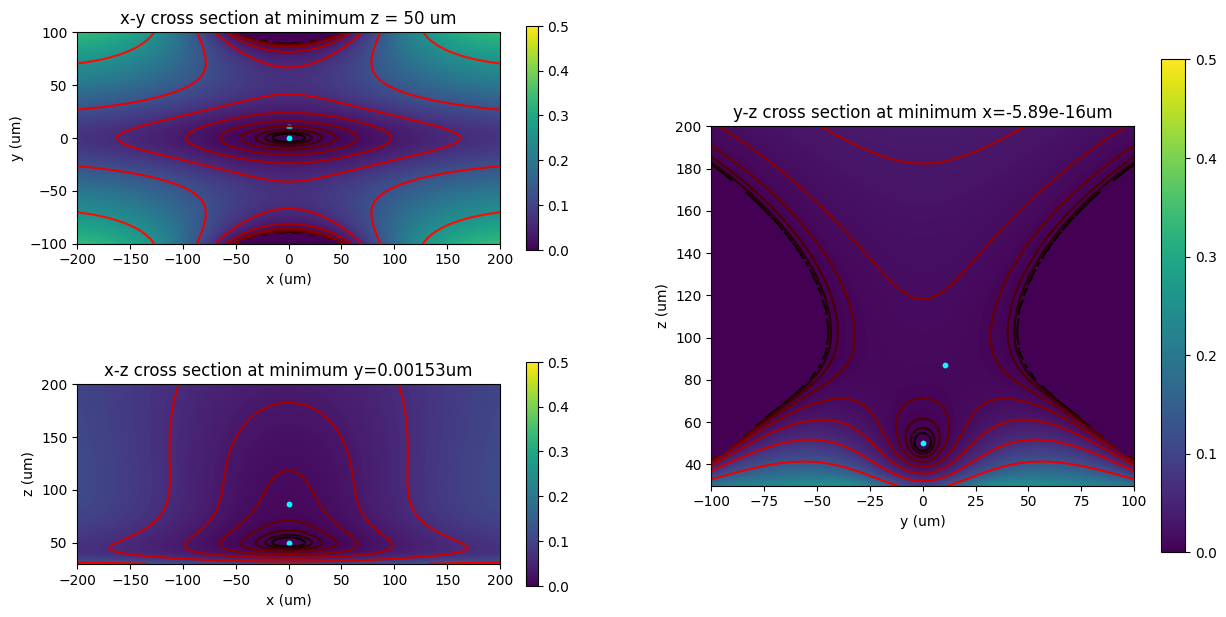

In [27]:
plot_potential_sections(s, x_cut, y_cut, z_cut, x0, [xs1], xmin, xmax, ymin, ymax, zmin, zmax, n, v_min, v_max, v, p_tot0)

In [28]:
# 1D plot settings
n = 200 # resolution of meshgrid (for 2D plots)

zmin1D = 40.
zmax1D = 350.
xmin1D = -1.5*abs(x0[0])
xmax1D = 1.5*abs(x0[0])
ymin1D = -1500.
ymax1D = 1500.

potmin1D = -50.
potmax1D = 1500. # in meV

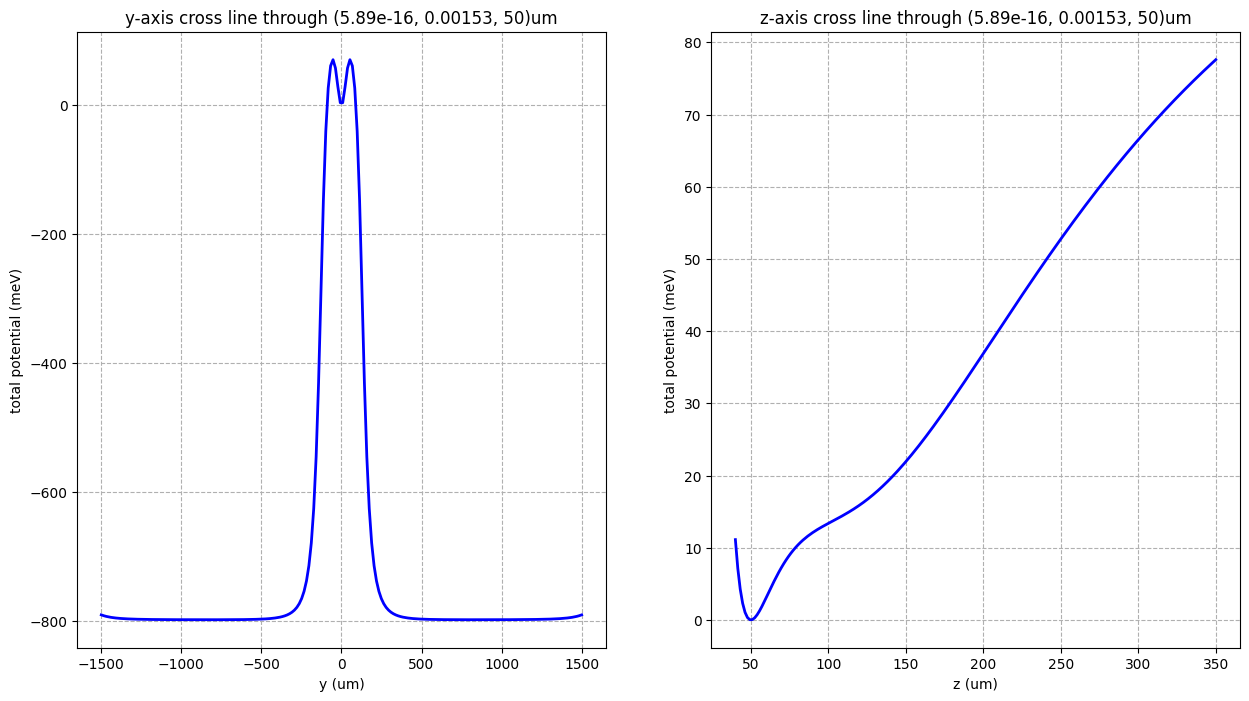

In [29]:
# Get data of cross line along y-direction
cross_line_y = np.mgrid[ymin1D:ymax1D:n*1j]
line_pot_y = np.copy(cross_line_y)
line_pot_y_b = np.copy(cross_line_y)
for i in range(0,n):
    x, y, z = x_cut, cross_line_y[i], z_cut
    line_pot_y[i] = s.potential((x,y,z), 0)[0]
    x, y, z = -x_cut, cross_line_y[i], z_cut
    line_pot_y_b[i] = s.potential((x,y,z), 0)[0]

# Get data of cross line along z-direction
cross_line_z = np.mgrid[zmin1D:zmax1D:n*1j]
line_pot_z = np.copy(cross_line_z)
for i in range(0,n):
    x, y, z = x_cut, y_cut, cross_line_z[i]
    line_pot_z[i] = s.potential((x,y,z), 0)[0]
    
# create figure to plot cross lines
fig, ax = plt.subplots(1,2,figsize=(15,8))

# Plot cross line along y
#ax[0].plot(cross_line_y, (line_pot_y-p_tot0)*1e3, 'r', lw=2) # cross line pos x direction
ax[0].plot(cross_line_y, (line_pot_y_b-p_tot0)*1e3, 'b', lw=2) # cross line neg x direction
ax[0].grid(linestyle='--')
ax[0].set_xlabel('y (um)')
ax[0].set_ylabel('total potential (meV)')
ax[0].set_title('y-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

# Plot cross line along x
ax[1].plot(cross_line_z, (line_pot_z-p_tot0)*1e3, 'b', lw=2)
ax[1].grid(linestyle='--')
ax[1].set_xlabel('z (um)')
ax[1].set_ylabel('total potential (meV)')
ax[1].set_title('z-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

plt.show()

In [36]:
# Define a grid for x
x_values = np.linspace(-800, 800, 200)  # 200 points in micrometers

# Storage for DC voltage shims at different x positions
uxx_vals, ux_vals, uy_vals, uz_vals = [], [], [], []

derivs = "xx x y z"

x0_positions = []

for x in x_values:
    x0_varied = (x, x0[1], x0[2])
    x0 = s.minimum(x0=x0_varied, axis=(1,2), coord=np.identity(3))
    x0_positions.append(x0)
    
# Compute shims for each x in the grid
for j, x in enumerate(x_values):
    with s.with_voltages(dcs=0*s.dcs, rfs=0*s.rfs):
        x0_varied = (x, x0[1], x0[2])  # Varying x while keeping y and  z constant
        u_cal = calc_shims(x0_varied, s_DC, derivs)

        uxx_vals.append(np.array(u_cal['xx'] * 1e-4))
        ux_vals.append(np.array(u_cal['x']) * 1e-2)
        uy_vals.append(np.array(u_cal['y']) * 1e-2)
        uz_vals.append(np.array(u_cal['z']) * 1e-2)

        for i, e in enumerate(s_DC):
            e.dc = uxx_vals[-1][i]        


        curve_z = s.modes(x0_positions[j])
        omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L

        target_freq = 1e6 * 2 * np.pi  # Convert MHz to angular frequency
        k = target_freq / omega_sec[0]

        # Scale the DC voltages
        for i, e in enumerate(s_DC):
            e.dc *= k**2

        uxx_vals[-1] *= k**2

# Convert lists to numpy arrays for easy processing
uxx_vals = np.array(uxx_vals)
ux_vals = np.array(ux_vals)
uy_vals = np.array(uy_vals)
uz_vals = np.array(uz_vals)

In [37]:
# Scale waveforms to 100 um lengthscale -> the scaling factor goes as the square!
waveforms = uxx_vals

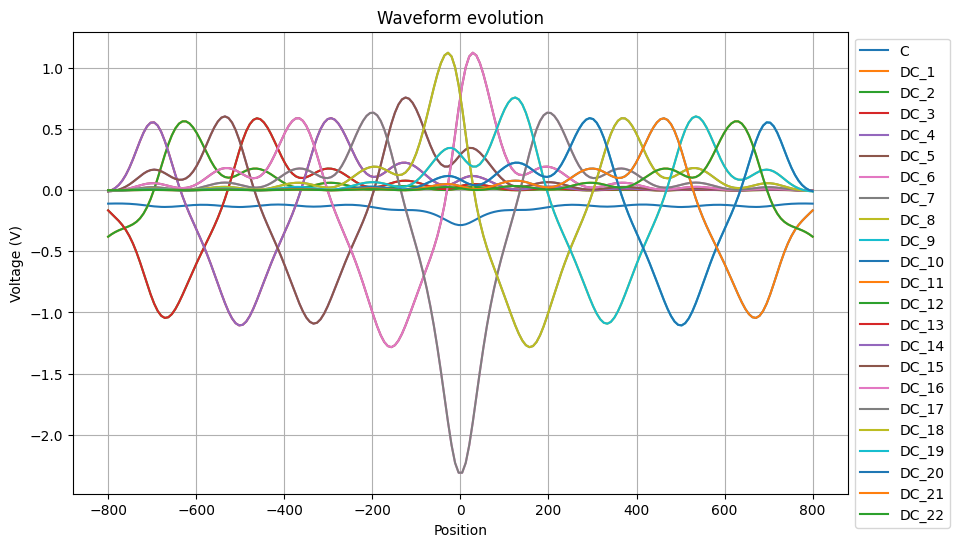

In [38]:
plt.figure(figsize=(10, 6))
for i, wf in enumerate(waveforms.T):
  plt.plot(x_values, wf, label=f"{s_DC.names[i]}")

plt.xlabel("Position")
plt.ylabel("Voltage (V)")
plt.title("Waveform evolution")

# Place the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  

plt.grid()
plt.show()

In [48]:
u_set = uxx_vals[0]
print("DC electrodes and their voltages:")

for i, e in enumerate(s_DC):
    e.dc = np.array(u_set[i])
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

DC electrodes and their voltages:
C: -0.8156727590239684
DC_1: -2.4440085631716006
DC_2: -1.0566191988871667
DC_3: -0.03971794731748588
DC_4: -0.057469427213839956
DC_5: -0.03997265797076752
DC_6: -0.025693185905528024
DC_7: -0.016743945996648153
DC_8: -0.011233554405303516
DC_9: -0.007759222239594865
DC_10: -0.005500711518621926
DC_11: -0.003988917055215438
DC_12: -2.443781875742646
DC_13: -1.0565915952868112
DC_14: -0.039720390765760144
DC_15: -0.05746825784870502
DC_16: -0.039971921362226
DC_17: -0.025692783920748963
DC_18: -0.016743718873963434
DC_19: -0.011233419554460198
DC_20: -0.007759138528265782
DC_21: -0.005500657565963833
DC_22: -0.003988881166749317
-------------------


In [49]:
# Print RF parameters
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))

print("-------------------")

# Compute minimum again
try:
    x0 = s.minimum(x0=(-700., 10., 10.), axis=(0,1,2), coord=np.identity(3))
    p_tot0 = s.potential(x0, 0)[0]
    print("The minimum of pseudopotential is: {0:.3g} eV\
          \nThe position of the minimum is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tot0, x0[0], x0[1], x0[2]))
except:
    print("minimum not found")
    x0 = (0., 0., 10.)
    
print("-------------------")

# Search for first saddle point
xs_start, ys_start, zs_start = x0[0], x0[1], x0[2] + 30
print("Initialization to find the first saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs1, p_tots1 = s.saddle([xs_start, ys_start, zs_start])
    print("The first saddle point energy is: {0:.3g} eV \
          \nThe position of the first saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots1, xs1[0], xs1[1], xs1[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Search for ssecond saddle point
xs_start, ys_start, zs_start = x0[0], x0[1] - 70, x0[2] + 70
print("Initialization to find the second saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs2, p_tots2 = s.saddle([xs_start, ys_start, zs_start])
    print("The second saddle point energy is: {0:.3g} eV \
          \nThe position of the second saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots2, xs2[0], xs2[1], xs2[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Compute secular frequencies
try:
    curve_z = s.modes(x0)
    omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")
    
print("-------------------")
    
# Compute maximum q-factor
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

RF drive frequency: 20 MHz
RF voltage: 10.2 V
-------------------
The minimum of pseudopotential is: -0.429 eV          
The position of the minimum is: (-800, -0.00669, 50) um
-------------------
Initialization to find the first saddle point: -800, -0.00669, 80
Saddle point not found
-------------------
Initialization to find the second saddle point: -800, -70, 120
Saddle point not found
-------------------
Secular frequencies: (0.6996, 1.681, 3.53) MHz
in directions [ 9.9992e-01 -5.3389e-06  1.2868e-02], [-1.2868e-02 -5.9086e-04  9.9992e-01], [ 2.2645e-06 -1.0000e+00 -5.9088e-04]
-------------------
max q-parameter 0.499, max q-param per Volt 0.0489
--> apply 8.17V for max q=0.4


In [50]:
# 2D plot settings
n = 100 # resolution of meshgrid (for 2D plots)

xmin, xmax = -1100., -500.
ymin, ymax = -100., 100.
zmin, zmax = 30., 200. 

x_cut, y_cut, z_cut = x0[0], x0[1], x0[2] # position of cross-sections at potential minimum
v_min, v_max = 0, .5 # range of color map (in eV) -> we rescale the potential
v = np.arange(-10,12) # spacing of contour lines -> can also be removed

/tmp/ipykernel_29054/3878294527.py:18: RuntimeWarning: invalid value encountered in log2
  CS = ax0.contour(x, y, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
/tmp/ipykernel_29054/3878294527.py:40: RuntimeWarning: invalid value encountered in log2
  CS = ax1.contour(x, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)
/tmp/ipykernel_29054/3878294527.py:60: RuntimeWarning: invalid value encountered in log2
  CS = ax2.contour(y, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)


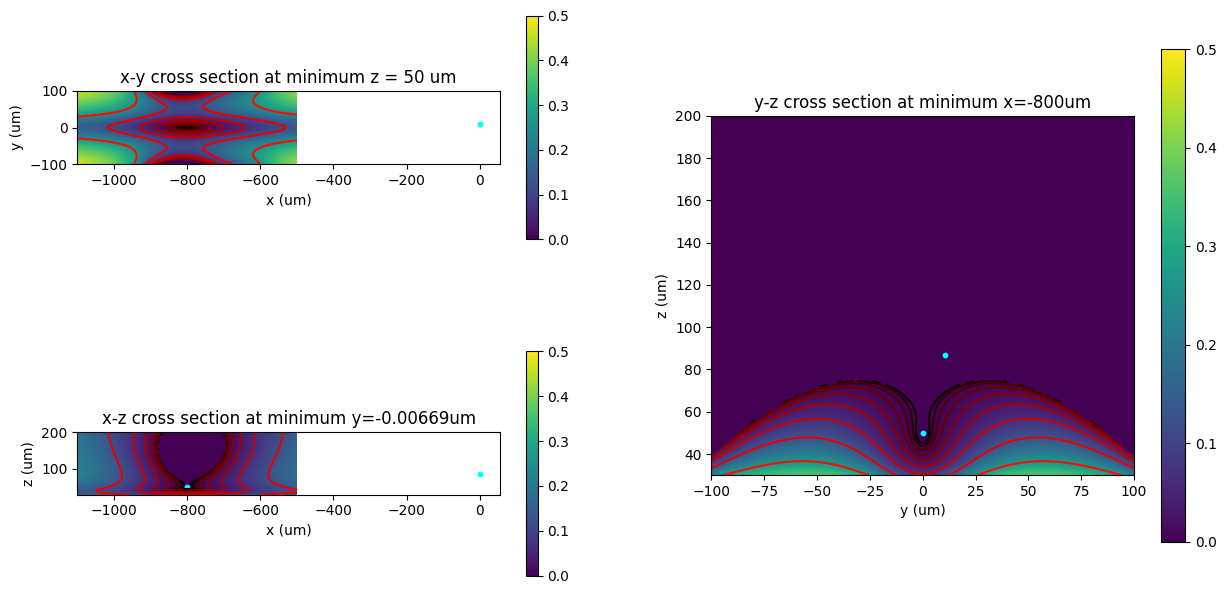

In [51]:
plot_potential_sections(s, x_cut, y_cut, z_cut, x0, [xs1], xmin, xmax, ymin, ymax, zmin, zmax, n, v_min, v_max, v, p_tot0)

In [120]:
u_set = uxx_vals[100]
print("DC electrodes and their voltages:")

for i, e in enumerate(s_DC):
    e.dc = np.array(u_set[i])
    print("{}: {}".format(e.name, e.dc))
    
print("-------------------")

DC electrodes and their voltages:
C: -0.8707156674511515
DC_1: 0.04562466067648475
DC_2: 0.09963695207138948
DC_3: 0.2588125510572162
DC_4: 0.8545608658643742
DC_5: 2.2428918369036586
DC_6: -6.41095989649194
DC_7: 1.9819242815399911
DC_8: 0.8095800707172162
DC_9: 0.23870546492297087
DC_10: 0.08954118073744445
DC_11: 0.04011780093975944
DC_12: -0.04562493536751268
DC_13: -0.09963764462825647
DC_14: -0.25881476963290084
DC_15: -0.8545716436267876
DC_16: -2.2429615267064675
DC_17: 6.41102810239274
DC_18: -1.981992689441429
DC_19: -0.8095909148340527
DC_20: -0.2387076617806961
DC_21: -0.0895418609736383
DC_22: -0.040118069804560175
-------------------


In [122]:
# Print RF parameters
print("RF drive frequency: {0:.4g} MHz".format(Omega/(2*np.pi*1e6)))
print("RF voltage: {} V".format(V_RF))

print("-------------------")

# Compute minimum again
try:
    x0 = s.minimum(x0=(0., 10., 10.), axis=(0,1,2), coord=np.identity(3))
    p_tot0 = s.potential(x0, 0)[0]
    print("The minimum of pseudopotential is: {0:.3g} eV\
          \nThe position of the minimum is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tot0, x0[0], x0[1], x0[2]))
except:
    print("minimum not found")
    x0 = (0., 0., 10.)
    
print("-------------------")

# Search for first saddle point
xs_start, ys_start, zs_start = x0[0], x0[1], x0[2] + 30
print("Initialization to find the first saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs1, p_tots1 = s.saddle([xs_start, ys_start, zs_start])
    print("The first saddle point energy is: {0:.3g} eV \
          \nThe position of the first saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots1, xs1[0], xs1[1], xs1[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Search for ssecond saddle point
xs_start, ys_start, zs_start = x0[0], x0[1] - 70, x0[2] + 70
print("Initialization to find the second saddle point: {0:.3g}, {1:.3g}, {2:.3g}"
      .format(xs_start, ys_start, zs_start))

try:
    xs2, p_tots2 = s.saddle([xs_start, ys_start, zs_start])
    print("The second saddle point energy is: {0:.3g} eV \
          \nThe position of the second saddle point is: ({1:.3g}, {2:.3g}, {3:.3g}) um"
          .format(p_tots2, xs2[0], xs2[1], xs2[2]))
except:
    print("Saddle point not found")

print("-------------------")

# Compute secular frequencies
try:
    curve_z = s.modes(x0)
    omega_sec = np.sqrt(Q * abs(curve_z[0]) / M) / L
    mode_directions = np.transpose(curve_z[1])
    print("Secular frequencies: ({0:.4g}, {1:.4g}, {2:.4g}) MHz"
          .format(omega_sec[0]/(2*np.pi)/1e6, 
                  omega_sec[1]/(2*np.pi)/1e6, 
                  omega_sec[2]/(2*np.pi)/1e6))
    print("in directions {0[0]}, {0[1]}, {0[2]}".format(mode_directions))
except:
    print("secular frequencies not found")
    
print("-------------------")
    
# Compute maximum q-factor
max_q = (max(omega_sec))/Omega*np.sqrt(8)
print("max q-parameter {0:.3g}, max q-param per Volt {1:.3g}".format(max_q, max_q/V_RF))
print("--> apply {0:.3g}V for max q=0.4".format(0.4/max_q*V_RF))

RF drive frequency: 20 MHz
RF voltage: 23.1 V
-------------------
The minimum of pseudopotential is: -0.491 eV          
The position of the minimum is: (4.09, 0.00343, 99.9) um
-------------------
Initialization to find the first saddle point: 4.09, 0.00343, 130
The first saddle point energy is: -0.485 eV           
The position of the first saddle point is: (4.29, 9.81, 136) um
-------------------
Initialization to find the second saddle point: 4.09, -70, 170
Saddle point not found
-------------------
Secular frequencies: (0.7, 1.288, 1.715) MHz
in directions [1.0000e+00 2.5137e-07 2.3855e-03], [ 2.3855e-03 -3.4797e-04 -1.0000e+00], [ 5.7874e-07  1.0000e+00 -3.4797e-04]
-------------------
max q-parameter 0.243, max q-param per Volt 0.0105
--> apply 38.1V for max q=0.4


In [125]:
# 2D plot settings
n = 100 # resolution of meshgrid (for 2D plots)

xmin, xmax = -500., 500.
ymin, ymax = -100., 100.
zmin, zmax = 30., 200. 

x_cut, y_cut, z_cut = x0[0], x0[1], x0[2] # position of cross-sections at potential minimum
v_min, v_max = 0, .5 # range of color map (in eV) -> we rescale the potential
v = np.arange(-10,12) # spacing of contour lines -> can also be removed

/tmp/ipykernel_15917/3878294527.py:60: RuntimeWarning: invalid value encountered in log2
  CS = ax2.contour(y, z, np.log2(p-p_tot0), v, cmap=plt.cm.hot)


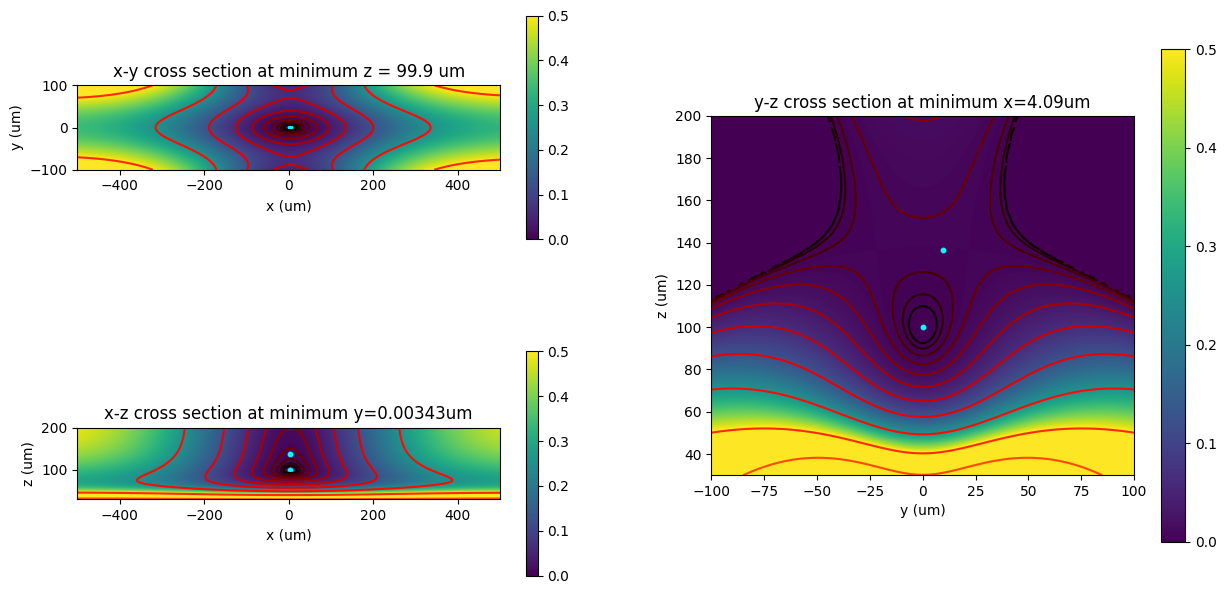

In [126]:
plot_potential_sections(s, x_cut, y_cut, z_cut, x0, [xs1], xmin, xmax, ymin, ymax, zmin, zmax, n, v_min, v_max, v, p_tot0)

In [127]:
# 1D plot settings
n = 200 # resolution of meshgrid (for 2D plots)

zmin1D = 70.
zmax1D = 350.
xmin1D = -1.5*abs(x0[0])
xmax1D = 1.5*abs(x0[0])
ymin1D = -1500.
ymax1D = 1500.

potmin1D = -50.
potmax1D = 1500. # in meV

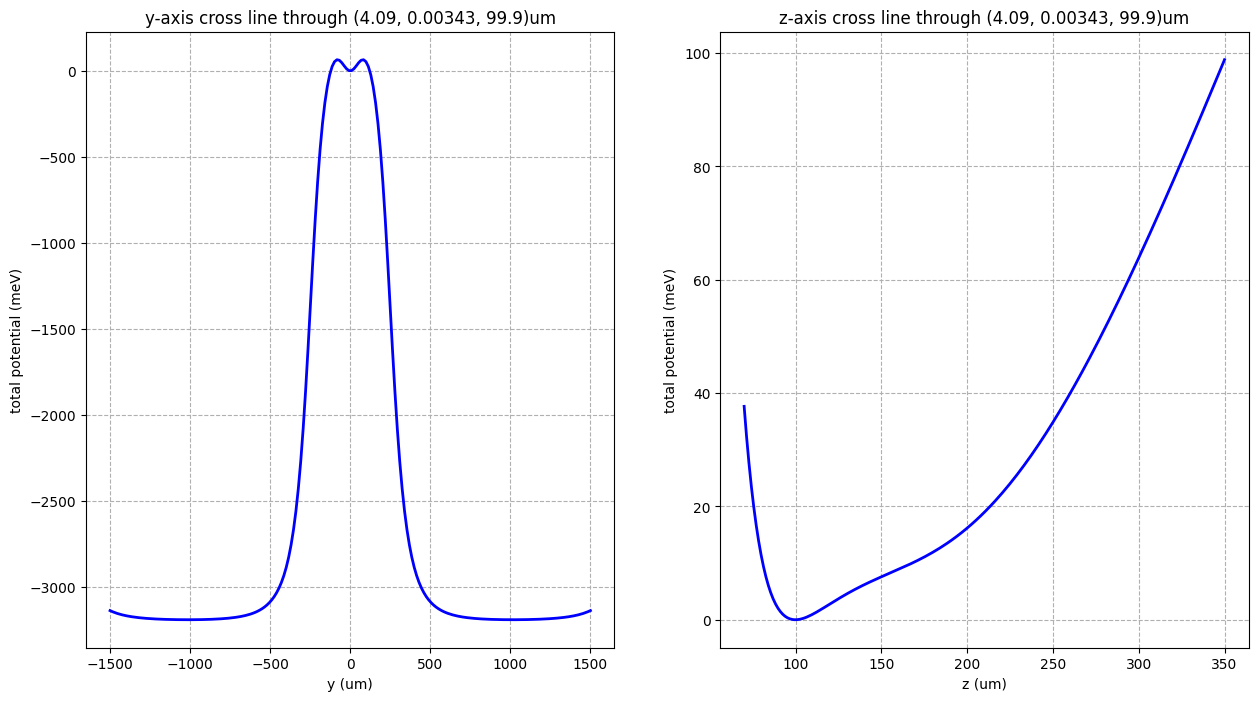

In [128]:
# Get data of cross line along y-direction
cross_line_y = np.mgrid[ymin1D:ymax1D:n*1j]
line_pot_y = np.copy(cross_line_y)
line_pot_y_b = np.copy(cross_line_y)
for i in range(0,n):
    x, y, z = x_cut, cross_line_y[i], z_cut
    line_pot_y[i] = s.potential((x,y,z), 0)[0]
    x, y, z = -x_cut, cross_line_y[i], z_cut
    line_pot_y_b[i] = s.potential((x,y,z), 0)[0]

# Get data of cross line along z-direction
cross_line_z = np.mgrid[zmin1D:zmax1D:n*1j]
line_pot_z = np.copy(cross_line_z)
for i in range(0,n):
    x, y, z = x_cut, y_cut, cross_line_z[i]
    line_pot_z[i] = s.potential((x,y,z), 0)[0]
    
# create figure to plot cross lines
fig, ax = plt.subplots(1,2,figsize=(15,8))

# Plot cross line along y
#ax[0].plot(cross_line_y, (line_pot_y-p_tot0)*1e3, 'r', lw=2) # cross line pos x direction
ax[0].plot(cross_line_y, (line_pot_y_b-p_tot0)*1e3, 'b', lw=2) # cross line neg x direction
ax[0].grid(linestyle='--')
ax[0].set_xlabel('y (um)')
ax[0].set_ylabel('total potential (meV)')
ax[0].set_title('y-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

# Plot cross line along x
ax[1].plot(cross_line_z, (line_pot_z-p_tot0)*1e3, 'b', lw=2)
ax[1].grid(linestyle='--')
ax[1].set_xlabel('z (um)')
ax[1].set_ylabel('total potential (meV)')
ax[1].set_title('z-axis cross line through ({0:.3g}, {1:.3g}, {2:.3g})um'.format(abs(x_cut), y_cut, z_cut))

plt.show()

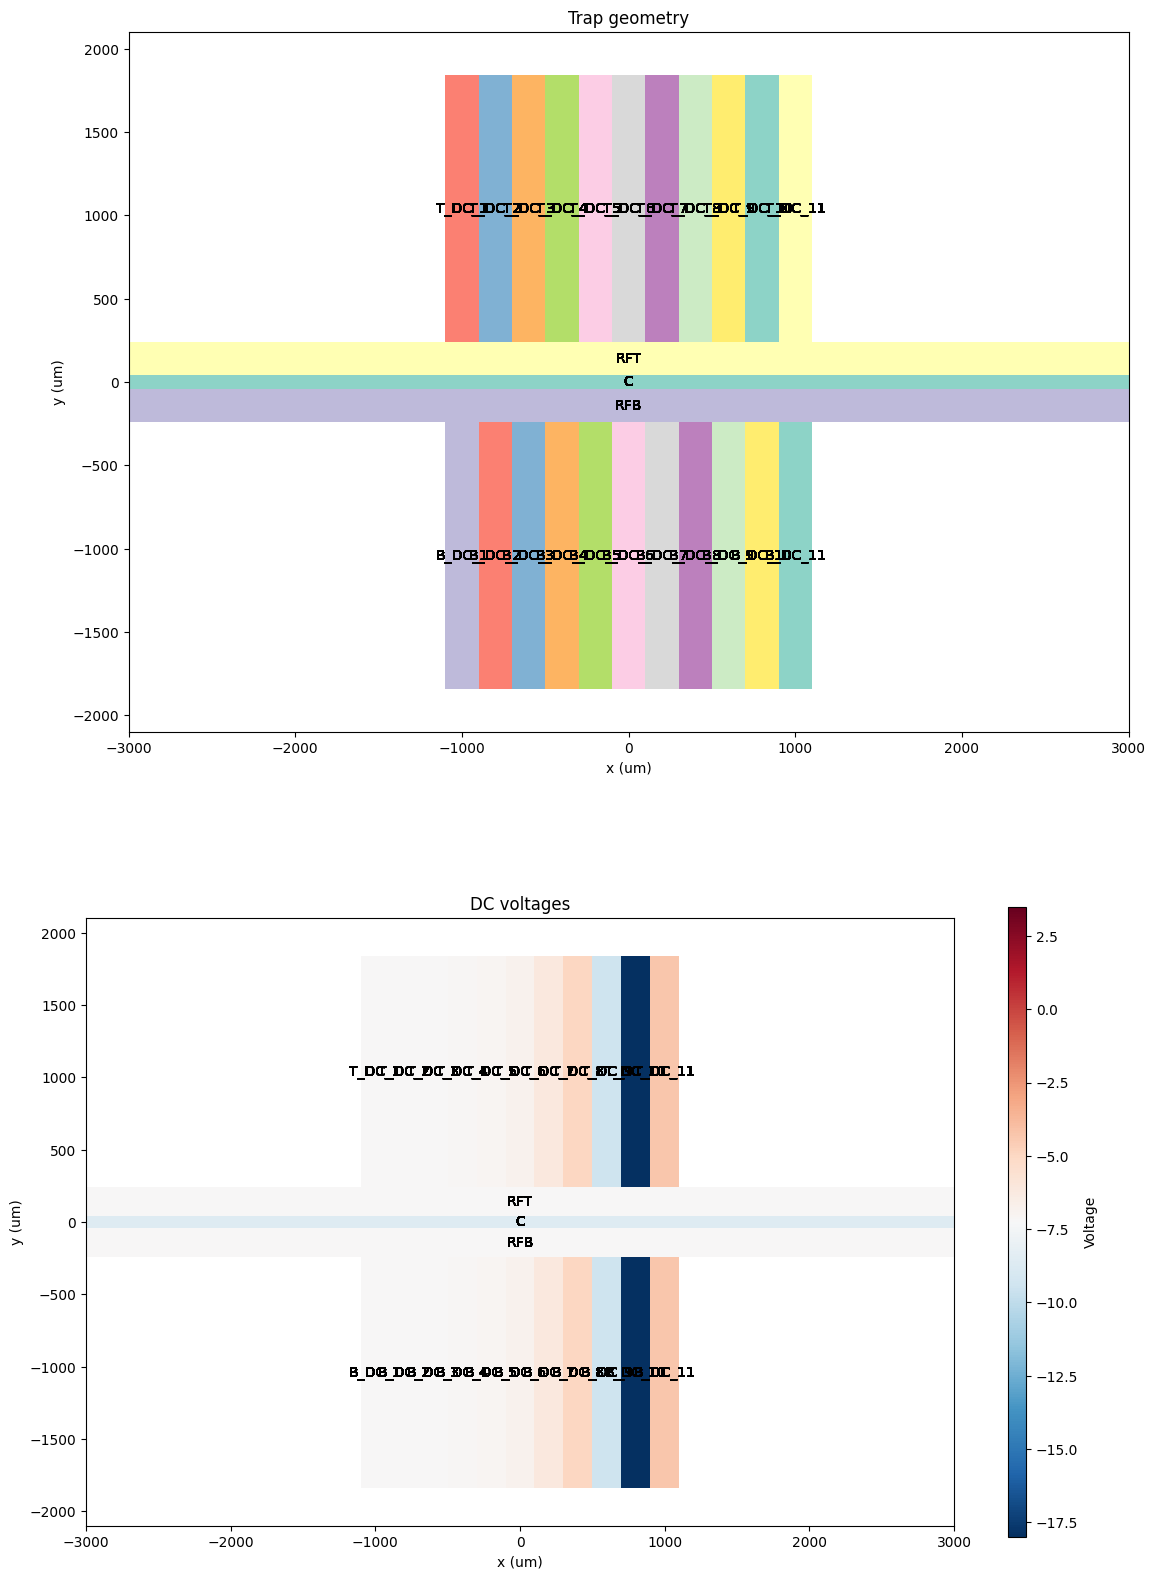

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation

# Create the figure and axes for the plots
fig, ax = plt.subplots(2, 1, figsize=(14,20))

# Set maximum values for the plot limits
xmax = 3000
ymax = 2100

# Set properties for the axes
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-xmax, xmax)
    axi.set_ylim(-ymax, ymax)
    axi.set_xlabel('x (um)')
    axi.set_ylabel('y (um)')

# Set titles for each plot
ax[0].set_title("Trap geometry")
ax[1].set_title("DC voltages")

# Build colormap for colorbars (normalized on voltage limit values)
vmin = np.min(s.dcs)
vmax = np.max(s.dcs)
cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Create the colorbars for DC voltages
cb1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], shrink=0.9, aspect=35)
cb1.ax.tick_params(labelsize=10)
cb1.set_label('Voltage', fontsize=10)

# Function to update the plots for each frame
def update(frame):
    for i, e in enumerate(s_DC):
        e.dc = uxx_vals[frame][i]
        
    s.plot(ax[0])  # Plot trap geometry (doesn't change with time)
    s.plot_voltages(ax[1], u=s.dcs)  # Update DC voltages for this frame
    
    return ax

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, len(x_values), 5), interval=500, blit=False)

# Save the animation as a GIF
ani.save('shuttling_animation.gif', writer='pillow', fps=10)

plt.show()


**Electrical fields**

In [181]:
E_field = []

for j in range(len(ux_vals)):
    u_set = 1e-3 * ux_vals[j]

    for i, e in enumerate(s_DC):
        e.dc = np.array(u_set[i])
     
    x = np.array([x_values[j], x0[1], x0[2]])
    E_field.append(s.potential(x, 1)[0])

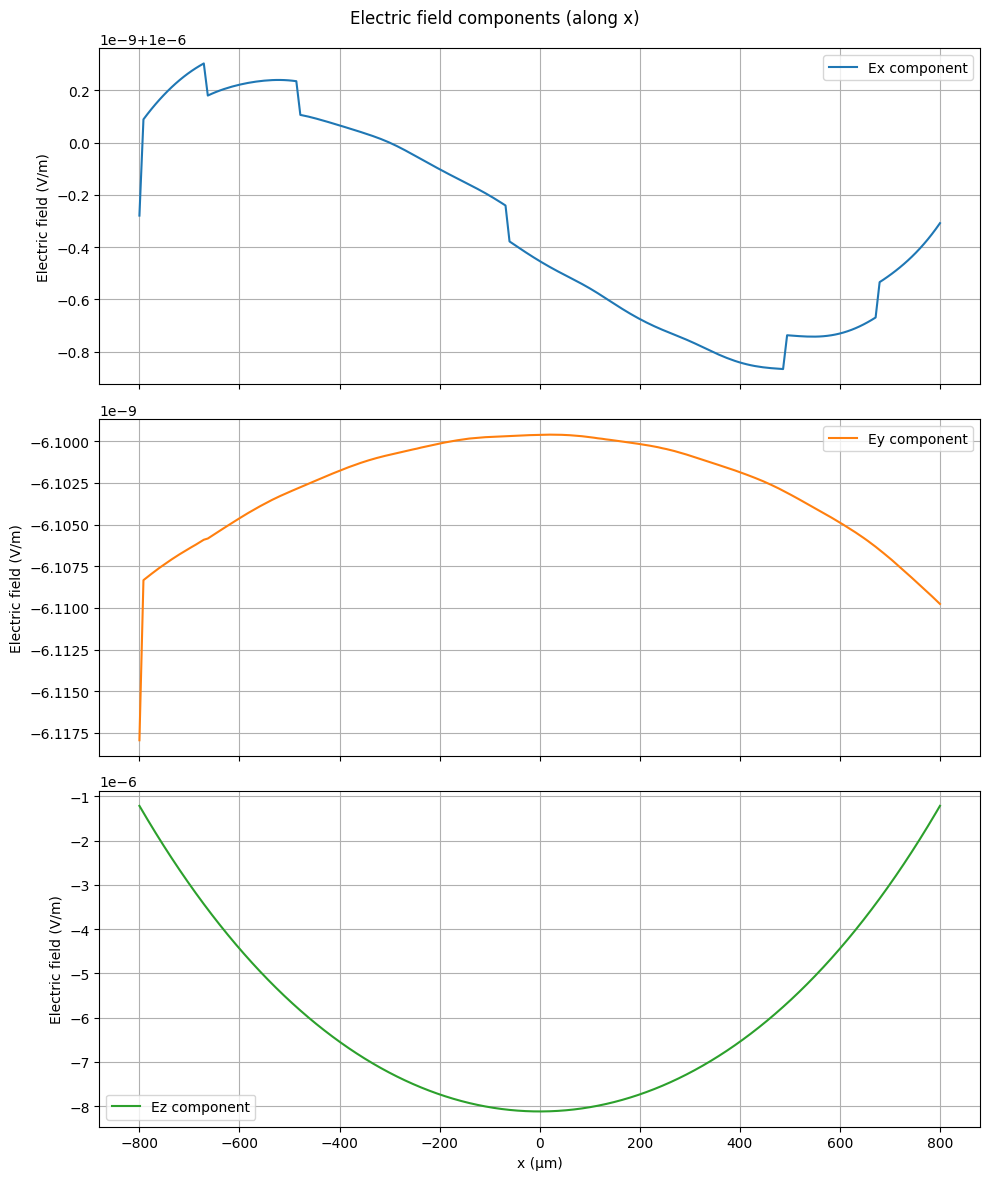

In [182]:
def plot_electric_field(E_field, x_values):
    E_field = np.array(E_field)  # Convert list to numpy array for easier indexing
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)  # Create subplots with shared x-axis
    
    components = ['Ex', 'Ey', 'Ez']
    for i in range(3):  # Loop over the three components
        ax[i].plot(x_values, E_field[:, i], label=f'{components[i]} component', color=f'C{i}')
        ax[i].set_ylabel('Electric field (V/m)')
        ax[i].legend()
        ax[i].grid(True)

    ax[-1].set_xlabel('x (μm)')  # Set x label on the last subplot
    fig.suptitle('Electric field components (along x)')

    plt.tight_layout()
    plt.show()

# Example usage
plot_electric_field(E_field, x_values)